In [1]:
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### CNN models ###
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
###########################################################
from tensorflow.keras.optimizers import SGD, RMSprop
##########################################################
from tensorflow.keras.utils import to_categorical
########################################################
from keras.layers import BatchNormalization
############################################################
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers

### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

In [2]:
#read the data
path = 'data/Fer2013/'
local_path = 'data/Fer2013/'

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'  #to suppress SettingWithCopyWarning

#Reading the dataset
dataset = pd.read_csv(local_path + 'icml_face_data.csv')

#Obtaining train data where usage is "Training"
train = dataset[dataset[" Usage"] == "Training"]

#Obtaining test data where usage is "PublicTest"
test = dataset[dataset[" Usage"] == "PublicTest"]


In [4]:
train

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
28704,2,Training,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705,0,Training,114 112 113 113 111 111 112 113 115 113 114 11...
28706,4,Training,74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707,0,Training,222 227 203 90 86 90 84 77 94 87 99 119 134 14...


In [5]:
#Converting " " separated pixel values to list
train[' pixels'] = train[' pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test[ ' pixels'] = test[' pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
dataset[' pixels'] = dataset[' pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

In [6]:
train

,emotion,Usage,pixels
0,0,Training,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63...."
1,0,Training,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111..."
2,2,Training,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161..."
3,4,Training,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20...."
4,6,Training,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
28704,2,Training,"[84.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85...."
28705,0,Training,"[114.0, 112.0, 113.0, 113.0, 111.0, 111.0, 112..."
28706,4,Training,"[74.0, 81.0, 87.0, 89.0, 95.0, 100.0, 98.0, 93..."
28707,0,Training,"[222.0, 227.0, 203.0, 90.0, 86.0, 90.0, 84.0, ..."


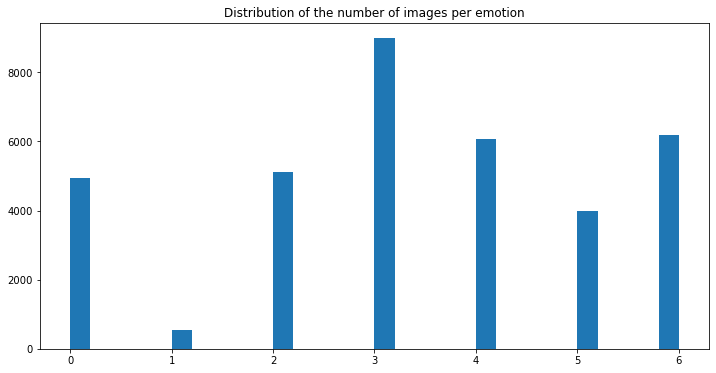

In [7]:
plt.figure(figsize=(12,6))
plt.hist(dataset['emotion'], bins=30)
plt.title("Distribution of the number of images per emotion")
plt.show()

In [8]:
print(train.shape)
print(test.shape)


(28709, 3)
(3589, 3)


In [9]:
##Create the data set
shape_x = 48
shape_y = 48

In [10]:
#train
X_train = train.iloc[:, 2].values
y_train = train.iloc[:, 0].values

#test
X_test = test.iloc[:, 2].values
y_test = test.iloc[:, 0].values

#all
X = dataset.iloc[:,2].values
y = dataset.iloc[:,0].values

In [11]:
print(X_train.shape)
print(X_train[0].shape)

(28709,)
(2304,)


In [12]:
#np.vstack stack arrays in sequence vertically (picking element row wise)
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
X = np.vstack(X)

In [13]:
# :)

print(X_train.shape)
print(X_train[0].shape)

(28709, 2304)
(2304,)


In [14]:
#Reshape X_train, y_train,X_test,y_test in desired formats
X_train = np.reshape(X_train, (X_train.shape[0],48,48,1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

X_test = np.reshape(X_test, (X_test.shape[0],48,48,1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

X = np.reshape(X, (X.shape[0],48,48,1))
y = np.reshape(y, (y.shape[0],1))

print("Shape of X_train and y_train is " + str(X_train.shape) +" and " + str(y_train.shape) +" respectively.")
print("Shape of X_test and y_test is " + str(X_test.shape) +" and " + str(y_test.shape) +" respectively.")

Shape of X_train and y_train is (28709, 48, 48, 1) and (28709, 1) respectively.
Shape of X_test and y_test is (3589, 48, 48, 1) and (3589, 1) respectively.


In [15]:
# Change to float datatype
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X = X.astype('float32')

In [16]:
#Feature Scaling
# Scale the data to lie between 0 to 1
X_train /= 255
X_test /= 255
X /= 255

In [17]:
# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)
y_labels_one_hot = to_categorical(y)

In [18]:
#Define Labels

# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)

Total number of outputs :  7
Output classes :  [0 1 2 3 4 5 6]


In [19]:


#Defining labels 
def get_label(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

Text(0.5, 1.0, 'Ground Truth : Surprise')

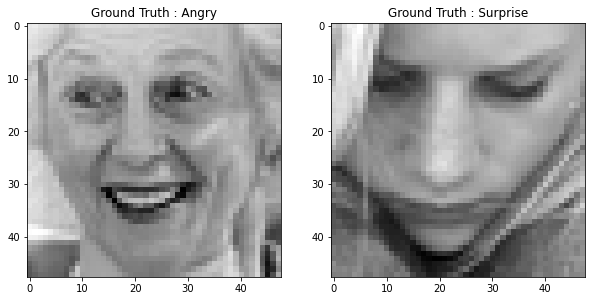

In [20]:
plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(np.squeeze(X_train[25,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[0]))))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(np.squeeze(X_test[26,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[1500]))))

In [21]:
# Detect Face

def detect_face(frame):
    
    #Cascade classifier pre-trained model
    cascPath = 'data/Fer2013/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)
    
    #BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE)
    coord = []
    
    for x, y, w, h in detected_faces :
        if w > 100 :
            sub_img=frame[y:y+h,x:x+w]
            #cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 255,255),1)
            coord.append([x,y,w,h])
    
    return gray, detected_faces, coord

In [22]:
#Extraire les features faciales
def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    gray = faces[0]
    detected_face = faces[1]
    
    new_face = []
    
    for det in detected_face :
        #Region dans laquelle la face est détectée
        x, y, w, h = det
        #X et y correspondent à la conversion en gris par gray, et w, h correspondent à la hauteur/largeur
    
        #Offset coefficient, np.floor takes the lowest integer (delete border of the image)
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))

        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #gray transforme l'image
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
    
        #Zoom sur la face extraite
        new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))
        #cast type float
        new_extracted_face = new_extracted_face.astype(np.float32)
        #scale
        new_extracted_face /= float(new_extracted_face.max())
        #print(new_extracted_face)
    
        new_face.append(new_extracted_face)
    
    return new_face

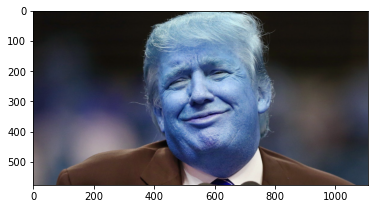

In [23]:
trump = 'data/Test_Images/trump.jpg'
trump_face = cv2.imread(trump, cv2.COLOR_BGR2RGB)
plt.imshow(trump_face)

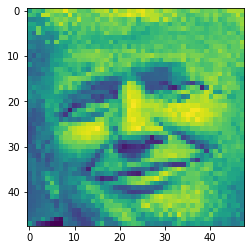

In [24]:

face = extract_face_features(detect_face(trump_face))[0]
plt.imshow(face)

In [25]:
#a first simple mode
def createModel():
    
    #Model Initialization
    model = Sequential() 
    
    #Adding Input Layer
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    
    #Adding more layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
  
    #Flattening
    model.add(Flatten())
    
    #Adding fully connected layer
    model.add(Dense(512, activation='relu'))
    
    model.add(Dropout(0.6))
    
    #Adding Output Layer
    model.add(Dense(nClasses, activation='softmax'))
     
    return model

In [26]:
#prevent_overfitting
def createModel2():
    
    #Model Initialization
    model = Sequential() 
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
 
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    
    #Flattening
    model.add(Flatten())
    
    #Adding fully connected layer
    model.add(Dense(512, activation='relu'))
    
    #Adding Output Layer
    model.add(Dense(nClasses, activation='softmax'))
     
    return model

In [27]:
#go_deeper
def createModel3():
    
    #Model Initialization
    model = Sequential() 
    
    model.add(Conv2D(20, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(30, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(40, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(50, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(60, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(70, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(80, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(90, (3, 3), padding='same', activation='relu'))
    
    #Flattening
    model.add(Flatten())
    
    #Adding fully connected layer
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(512, activation='relu'))
    
    #Adding Output Layer
    model.add(Dense(nClasses, activation='softmax'))
     
    return model

In [28]:
#build_model
model = createModel3()

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 20)        200       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 30)        5430      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 30)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 30)        120       
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 40)        10840     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 50)        1

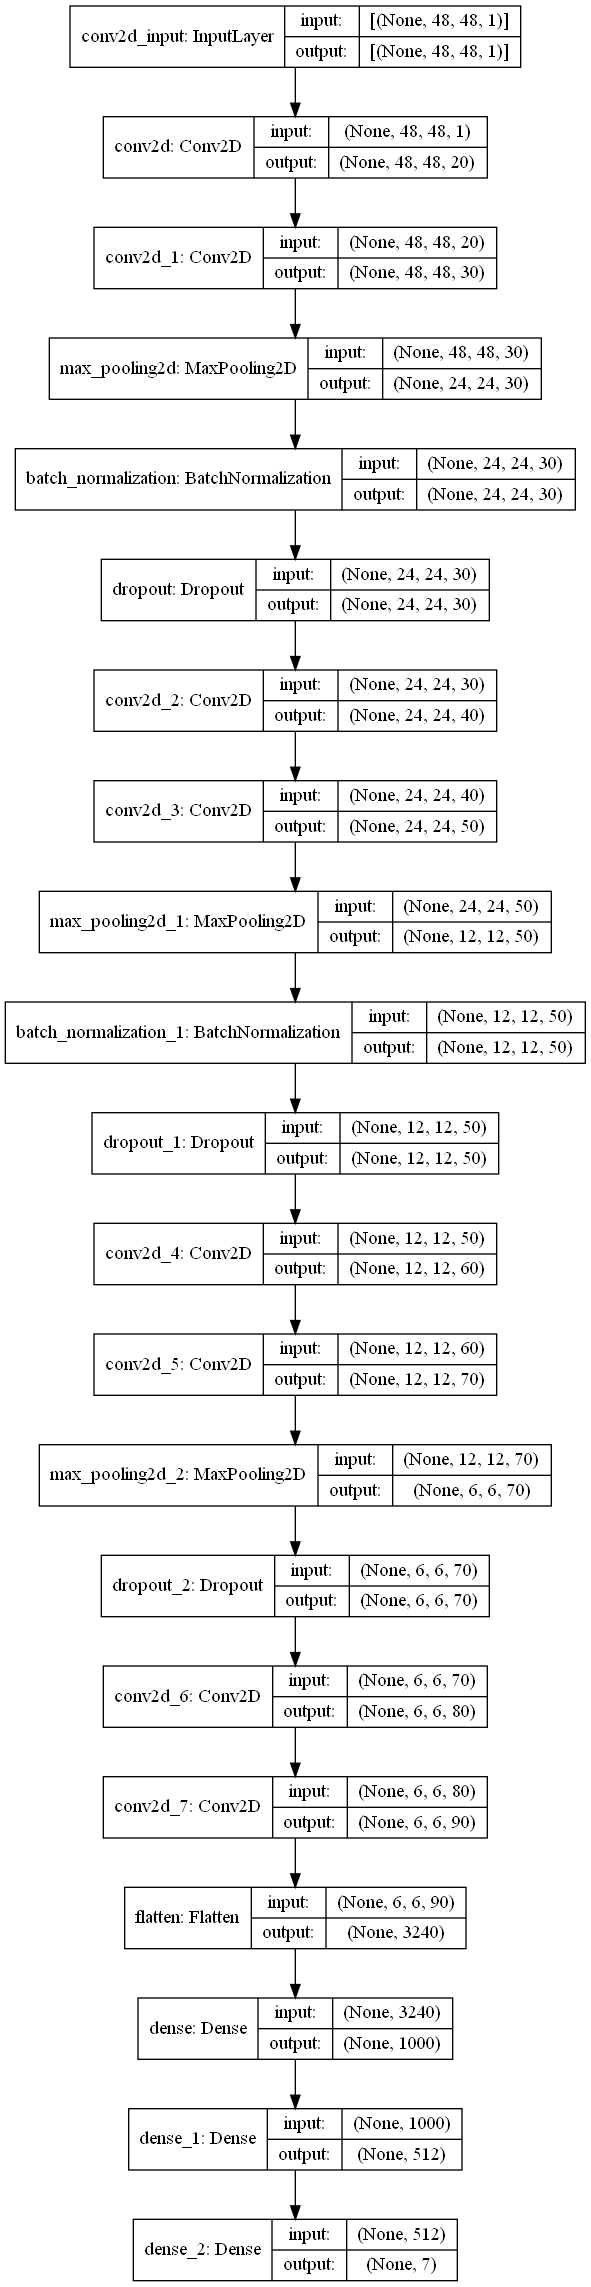

In [30]:
plot_model(model, to_file='data/model_images/model_plot.png', show_shapes=True, show_layer_names=True)

In [31]:
#Visualize layers and output
layer_outputs = [layer.output for layer in model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [32]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

In [33]:
trump = 'data/Test_Images/trump.jpg'
trump_face = cv2.imread(trump)
face = extract_face_features(detect_face(trump_face))[0]

to_predict = np.reshape(face.flatten(), (1,48,48,1))
res = model.predict(to_predict)
activations = activation_model.predict(to_predict)

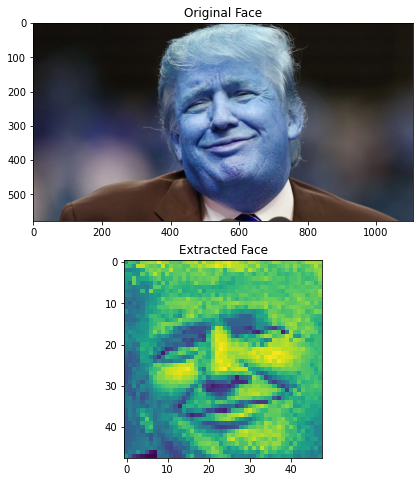

In [34]:
plt.figure(figsize=(12,8))

plt.subplot(211)
plt.title("Original Face")
plt.imshow(trump_face)

plt.subplot(212)
plt.title("Extracted Face")
plt.imshow(face)

plt.show()

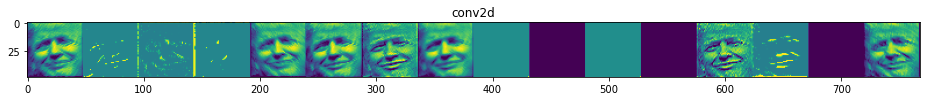

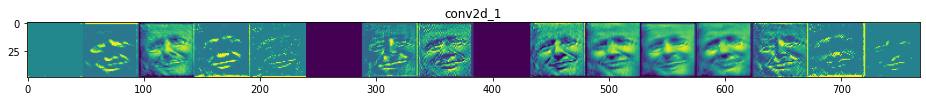

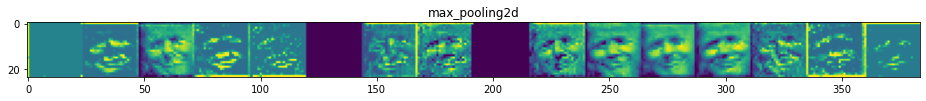

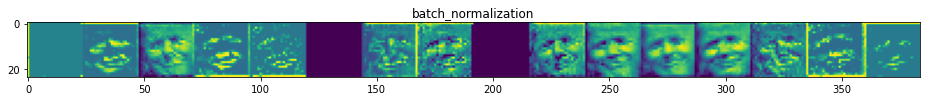

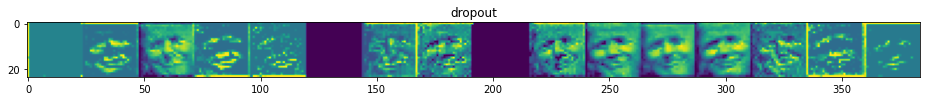

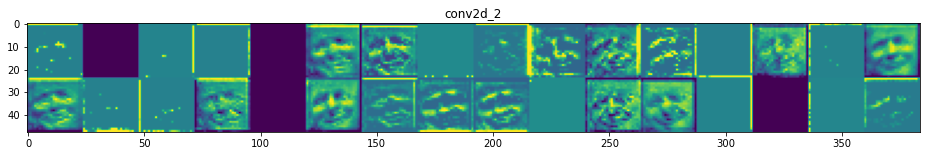

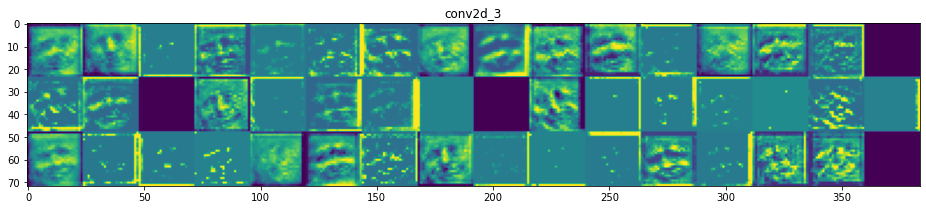

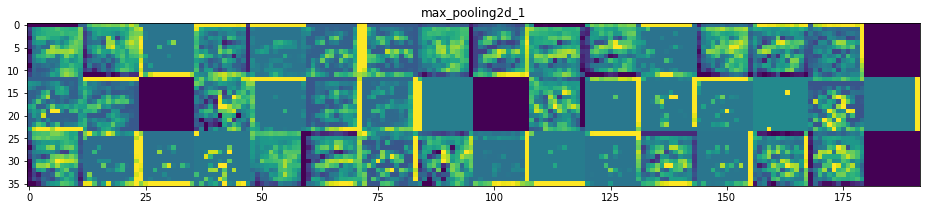

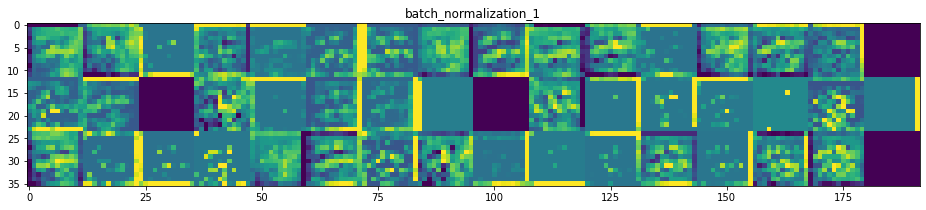

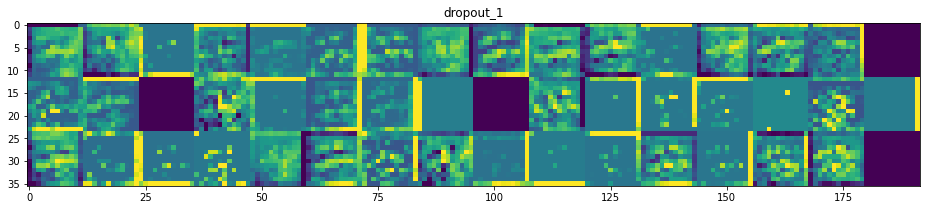

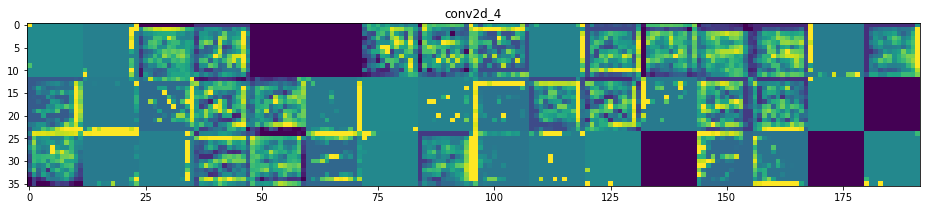

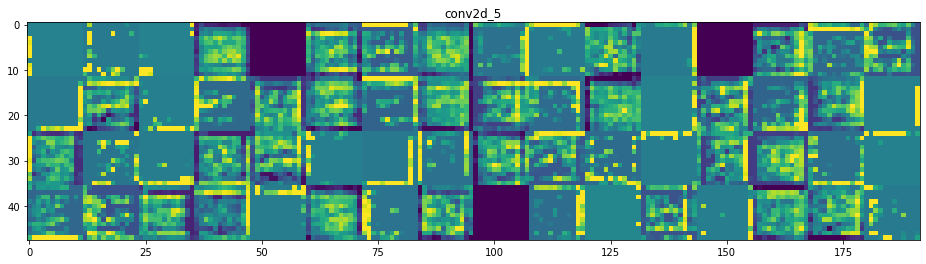

In [36]:
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [38]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

In [40]:
#Creating 2nd model and training(fitting)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 256
##
epochs = 10
##
# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(
    datagen.flow(X_train, train_labels_one_hot, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs, 
    validation_data=(X_test, test_labels_one_hot)
)

Epoch 1/10
113/113 [==============================] - 103s 903ms/step - loss: 1.5679 - accuracy: 0.3825 - val_loss: 1.8761 - val_accuracy: 0.1895
Epoch 2/10
113/113 [==============================] - 103s 909ms/step - loss: 1.4558 - accuracy: 0.4361 - val_loss: 1.8227 - val_accuracy: 0.3012
Epoch 3/10
113/113 [==============================] - 104s 917ms/step - loss: 1.3968 - accuracy: 0.4612 - val_loss: 1.5687 - val_accuracy: 0.3959
Epoch 4/10
113/113 [==============================] - 104s 915ms/step - loss: 1.3415 - accuracy: 0.4840 - val_loss: 1.2710 - val_accuracy: 0.5026
Epoch 5/10
113/113 [==============================] - 103s 915ms/step - loss: 1.3043 - accuracy: 0.4939 - val_loss: 1.2723 - val_accuracy: 0.5127
Epoch 6/10
113/113 [==============================] - 104s 919ms/step - loss: 1.2667 - accuracy: 0.5111 - val_loss: 1.2458 - val_accuracy: 0.5233
Epoch 7/10
113/113 [==============================] - 103s 914ms/step - loss: 1.2458 - accuracy: 0.5243 - val_loss: 1.1616 -

In [41]:
len(X_test)

3589

Text(0.5, 1.0, 'Accuracy Curves')

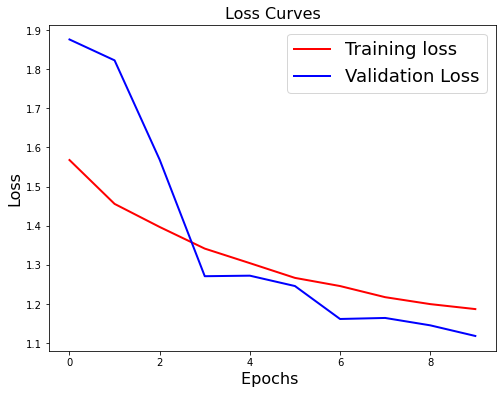

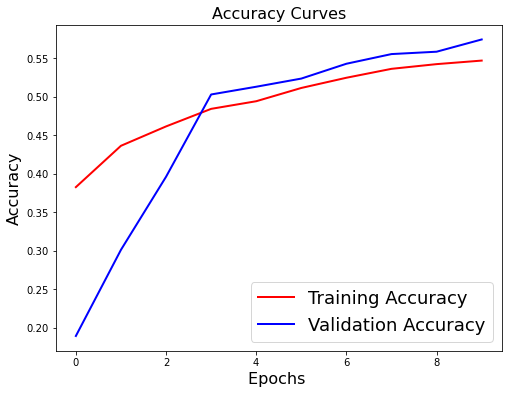

In [42]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [43]:
#save the model weights
json_string = model.to_json()
model.save_weights(local_path + '/savedmodels/model_3.h5/')
open(local_path + 'savedmodels/model_3.json', 'w').write(json_string)
#model.save_weights(local_path + 'savedmodels/Emotion_Face_Detection_Model.h5')

8358

In [44]:
with open(local_path + 'savedmodels/model_3.json','r') as f:
    json = f.read()
model = model_from_json(json)

model.load_weights(local_path + '/savedmodels/model_3.h5/')
print("Loaded model from disk")

Loaded model from disk


In [45]:
hanks = 'data/Test_Images//hanks_vs.jpg'
hanks_face = cv2.imread(hanks)

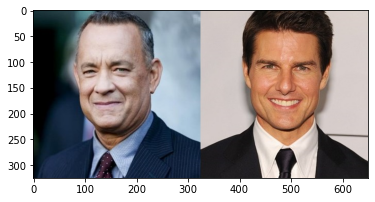

In [46]:
plt.imshow(cv2.cvtColor(hanks_face, cv2.COLOR_BGR2RGB))

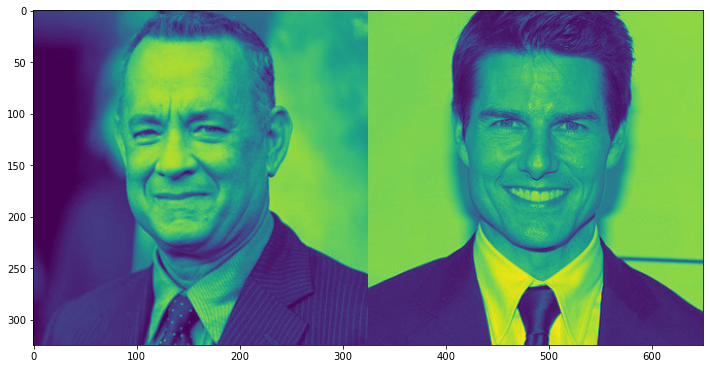

In [47]:
plt.figure(figsize=(12,12))
plt.imshow(detect_face(hanks_face)[0])
plt.show()

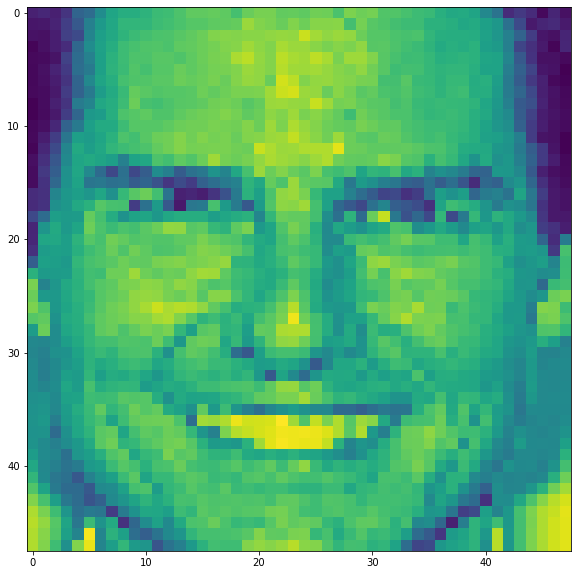

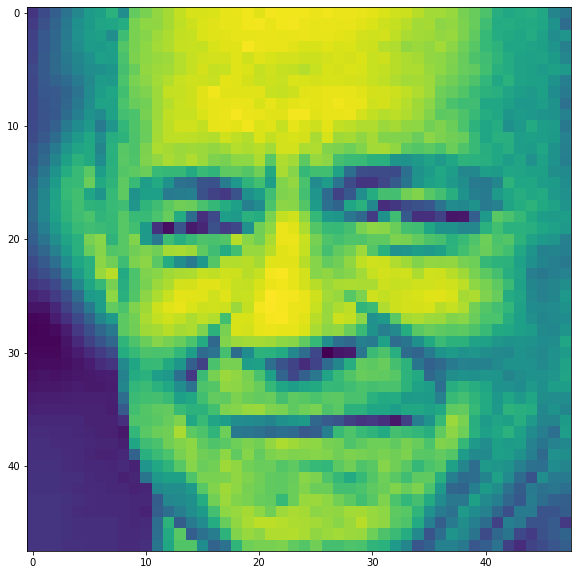

In [48]:
for face in extract_face_features(detect_face(hanks_face)) :
    plt.figure(figsize=(10,10))
    plt.imshow(face)
    plt.show()

In [49]:
for face in extract_face_features(detect_face(hanks_face)) :
    to_predict = np.reshape(face.flatten(), (1,48,48,1))
    res = model.predict(to_predict)
    result_num = np.argmax(res)
    print(get_label(result_num))

Happy
Happy


In [50]:
#Lancer la capture video
video_capture = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_SIMPLEX

emotion = []

xs = []
ys = []

i = 0

while True:
    # Capture frame-by-frame
    # sleep(0.8)
    ret, frame = video_capture.read()
    
    face_index = 0
    gray, detected_faces, coord = detect_face(frame)

    try :
        for face in detected_faces :
            face = extract_face_features(gray, face)
            face = np.reshape(face.flatten(), (1,48,48,1))
            x,y,w,h = detect_face(frame)[2][face_index]
        
            #if w > 200 : 
            #Dessiner rectangle autour de la tête
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # predict smile
            prediction = model.predict(face)
            prediction_result = np.argmax(prediction)
       
            cv2.putText(frame, "Angry : " + str(round(prediction[0][0],3)),(10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Disgust : " + str(round(prediction[0][1],3)),(10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Fear : " + str(round(prediction[0][2],3)),(10,70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Happy : " + str(round(prediction[0][3],3)),(10,90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Sad : " + str(round(prediction[0][4],3)),(10,110), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Surprise : " + str(round(prediction[0][5],3)),(10,130), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Neutral : " + str(round(prediction[0][6],3)),(10,150), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
        
            # draw extracted face in the top right corner
            #frame[face_index * shape_x: (face_index + 1) * shape_x, -1 * shape_y - 1:-1, :] = cv2.cvtColor(extracted_face * 255, cv2.COLOR_GRAY2RGB)

            # annotate main image with a label
            if prediction_result == 0 :
                cv2.putText(frame, "Angry",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            elif prediction_result == 1 :
                cv2.putText(frame, "Disgust",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            elif prediction_result == 2 :
                cv2.putText(frame, "Fear",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            elif prediction_result == 3 :
                cv2.putText(frame, "Happy",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            elif prediction_result == 4 :
                cv2.putText(frame, "Sad",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            elif prediction_result == 5 :
                cv2.putText(frame, "Surprise",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            else :
                cv2.putText(frame, "Neutral",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
           
        #emotion.append(prediction_result)
        #xs.append(i)
        #ys.append(prediction_result)
        
        #line1, = ax.plot(i, prediction_result, 'b-') 
       # line1.set_ydata(prediction_result)
       # fig.canvas.draw()
            
        #print(prediction_result)
               
            face_index += 1
        i = i + 1
    except :
        continue 
    # Display the resulting frame
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

#%matplotlib qt
#plt.bar(xs, ys)

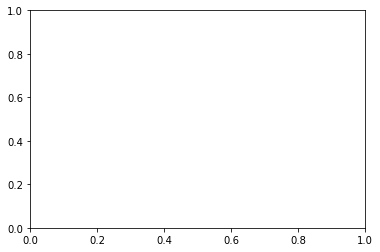

In [51]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

def animate(i) :
    graph_data = emotion
    xs = []
    ys = []
    for emo in graph_data:
        xs.append(emo[0])
        ys.append(emo[1])
    ax1.clear()
    ax1.plot(xs,ys)

ani = animation.FuncAnimation(fig, animate, interval=1000)
plt.show()

In [52]:
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

In [53]:
thresh = 0.25
frame_check = 20
face_detect = dlib.get_frontal_face_detector()
predictor_landmarks = dlib.shape_predictor(local_path + 'face_landmarks.dat')

In [54]:
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

In [55]:
(nStart, nEnd) = face_utils.FACIAL_LANDMARKS_IDXS["nose"]
(mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
(jStart, jEnd) = face_utils.FACIAL_LANDMARKS_IDXS["jaw"]

(eblStart, eblEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
(ebrStart, ebrEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]

In [56]:
desiredLeftEye=(0.35, 0.35)

def align(gray, rect):
    # convert the landmark (x, y)-coordinates to a NumPy array
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
 
    # extract the left and right eye (x, y)-coordinates
    (lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = shape[lStart:lEnd]
    rightEyePts = shape[rStart:rEnd]
        
    # compute the center of mass for each eye
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
 
    # compute the angle between the eye centroids
    dY = rightEyeCenter[1] - leftEyeCenter[1]
    dX = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dY, dX)) - 180
        
    # compute the desired right eye x-coordinate based on the
    # desired x-coordinate of the left eye
    desiredRightEyeX = 1.0 - desiredLeftEye[0]
 
    # determine the scale of the new resulting image by taking
    # the ratio of the distance between eyes in the *current*
    # image to the ratio of distance between eyes in the
    # *desired* image
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desiredDist = (desiredRightEyeX - desiredLeftEye[0])
    desiredDist *= self.desiredFaceWidth
    scale = desiredDist / dist
        
    # compute center (x, y)-coordinates (i.e., the median point)
    # between the two eyes in the input image
    eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)
 
    # grab the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
 
    # update the translation component of the matrix
    tX = self.desiredFaceWidth * 0.5
    tY = self.desiredFaceHeight * self.desiredLeftEye[1]
    M[0, 2] += (tX - eyesCenter[0])
    M[1, 2] += (tY - eyesCenter[1])
        
    # apply the affine transformation
    (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
    #output = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
    output = cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_CUBIC)
    # return the aligned face
    return output

In [57]:
#Lancer la capture video
video_capture = cv2.VideoCapture(0)
flag = 0
j = 1

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    
    face_index = 0
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = face_detect(gray, 1)
    #gray, detected_faces, coord = detect_face(frame)
    
    for (i, rect) in enumerate(rects):
        
        shape = predictor_landmarks(gray, rect)
        shape = face_utils.shape_to_np(shape)
    
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        face = gray[y:y+h,x:x+w]
        
        #Zoom sur la face extraite
        face = zoom(face, (shape_x / face.shape[0],shape_y / face.shape[1]))
        #cast type float
        face = face.astype(np.float32)
        #scale
        face /= float(face.max())
        face = np.reshape(face.flatten(), (1, 48, 48, 1))
        prediction = model.predict(face)
        prediction_result = np.argmax(prediction)
        
        # Rectangle around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
        cv2.putText(frame, "Face #{}".format(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
 
        for (j, k) in shape:
            cv2.circle(frame, (j, k), 1, (0, 0, 255), -1)

         # 12. Add prediction probabilities
        cv2.putText(frame, "Emotional report : ",(40,120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
        cv2.putText(frame, "Angry : " + str(round(prediction[0][0],3)),(40,140), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
        cv2.putText(frame, "Disgust : " + str(round(prediction[0][1],3)),(40,160), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
        cv2.putText(frame, "Fear : " + str(round(prediction[0][2],3)),(40,180), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
        cv2.putText(frame, "Happy : " + str(round(prediction[0][3],3)),(40,200), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
        cv2.putText(frame, "Sad : " + str(round(prediction[0][4],3)),(40,220), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
        cv2.putText(frame, "Surprise : " + str(round(prediction[0][5],3)),(40,240), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
        cv2.putText(frame, "Neutral : " + str(round(prediction[0][6],3)),(40,260), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
        
        # draw extracted face in the top right corner
        #frame[face_index * shape_x: (face_index + 1) * shape_x, -1 * shape_y - 1:-1, :] = cv2.cvtColor(face * 255, cv2.COLOR_GRAY2RGB)

        # 13. Annotate main image with a label
        if prediction_result == 0 :
            cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        elif prediction_result == 1 :
            cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        elif prediction_result == 2 :
            cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        elif prediction_result == 3 :
            cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        elif prediction_result == 4 :
            cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        elif prediction_result == 5 :
            cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        else :
            cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                   
        
        # 5. Eye Detection and Blink Count
        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]
        
        # Compute Eye Aspect Ratio
        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)
        ear = (leftEAR + rightEAR) / 2.0
            
        # And plot its contours
        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)
        
        # Compute total blinks and frequency
        if ear < thresh:
            flag += 1
            #cv2.putText(frame, "Blink", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
        
        cv2.putText(frame, "Total blinks : " + str(flag), (40, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, 155, 1)
        #cv2.putText(frame, "Blink Frequency : " + str(int(flag/j)), (40, 220), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
        
        # 6. Detect Nose
        nose = shape[nStart:nEnd]
        noseHull = cv2.convexHull(nose)
        cv2.drawContours(frame, [noseHull], -1, (0, 255, 0), 1)

        # 7. Detect Mouth
        mouth = shape[mStart:mEnd]
        mouthHull = cv2.convexHull(mouth)
        cv2.drawContours(frame, [mouthHull], -1, (0, 255, 0), 1)
            
        # 8. Detect Jaw
        jaw = shape[jStart:jEnd]
        jawHull = cv2.convexHull(jaw)
        cv2.drawContours(frame, [jawHull], -1, (0, 255, 0), 1)
            
        # 9. Detect Eyebrows
        ebr = shape[ebrStart:ebrEnd]
        ebrHull = cv2.convexHull(ebr)
        cv2.drawContours(frame, [ebrHull], -1, (0, 255, 0), 1)
        ebl = shape[eblStart:eblEnd]
        eblHull = cv2.convexHull(ebl)
        cv2.drawContours(frame, [eblHull], -1, (0, 255, 0), 1)
            
    cv2.putText(frame,'Number of Faces : ' + str(i+1),(40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, 155, 1)
    j = j + 1
    cv2.imshow('Video', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

# XV. Deeper CNN Models


In [58]:
input_img = Input(shape=(shape_x, shape_y, 1))

layer1 = Conv2D(10, (3, 3), padding='same', activation='relu')(input_img)
layer1_2 = Conv2D(20, (3, 3), padding='same', activation='relu')(layer1)
layer2 = MaxPooling2D(pool_size=(3, 3))(layer1_2)
bn1 = BatchNormalization()(layer2)

layer3 = Conv2D(30, (3, 3), padding='same', activation='relu')(bn1)
layer3_2 = Conv2D(40, (3, 3), padding='same', activation='relu')(layer3)
layer4 = MaxPooling2D(pool_size=(3, 3))(layer3_2)
bn2 = BatchNormalization()(layer4)

layer5 = Conv2D(50, (3, 3), padding='same', activation='relu')(bn2)
layer5_2 = Conv2D(60, (3, 3), padding='same', activation='relu')(layer5)
layer6 = MaxPooling2D(pool_size=(3, 3))(layer5_2)
bn3 = BatchNormalization()(layer6)

Conv11 = Conv2D(1, (1, 1), padding='same', activation='relu')(bn3)
Conv33 = Conv2D(4, (3, 3), padding='same', activation='relu')(bn3)
Conv332 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv33)
Conv55 = Conv2D(4, (5, 5), padding='same', activation='relu')(bn3)
Conv552 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv55)
#Pool33 = MaxPooling2D(pool_size=(3, 3))(bn3)
#ConvPool1 = Conv2D(4, (1, 1), padding='same', activation='relu')(Pool33)

intermediate1 = keras.layers.concatenate([Conv11, Conv332, Conv552], axis=1)

Conv2_11 = Conv2D(1, (1, 1), padding='same', activation='relu')(intermediate1)
Conv2_33 = Conv2D(4, (3, 3), padding='same', activation='relu')(intermediate1)
Conv2_332 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv2_33)
Conv2_55 = Conv2D(4, (5, 5), padding='same', activation='relu')(intermediate1)
Conv2_552 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv2_55)
#Pool2_33 = MaxPooling2D(pool_size=(3, 3))(intermediate1)
#ConvPool2 = Conv2D(4, (1, 1), padding='same', activation='relu')(Pool2_33)

intermediate2 = keras.layers.concatenate([Conv2_11, Conv2_332, Conv2_552], axis=1)

Conv3_11 = Conv2D(1, (1, 1), padding='same', activation='relu')(intermediate2)
Conv3_33 = Conv2D(4, (3, 3), padding='same', activation='relu')(intermediate2)
Conv3_332 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv3_33)
Conv3_55 = Conv2D(4, (5, 5), padding='same', activation='relu')(intermediate2)
Conv3_552 = Conv2D(1, (3, 3), padding='same', activation='relu')(Conv3_55)
#Pool3_33 = MaxPooling2D(pool_size=(3, 3))(intermediate2)
#ConvPool3 = Conv2D(4, (1, 1), padding='same', activation='relu')(Pool3_33)

intermediate3 = keras.layers.concatenate([Conv3_11, Conv3_332, Conv3_552], axis=1)

#Pool4 = MaxPooling2D(pool_size=(3, 3))(intermediate3)

Flat = Flatten()(intermediate3)

Dense1 = Dense(25, activation='relu')(Flat)
Dense2 = Dense(15, activation='relu')(Dense1)
Dense3 = Dense(7, activation='softmax')(Dense2)

In [59]:
model = Model([input_img], Dense3)

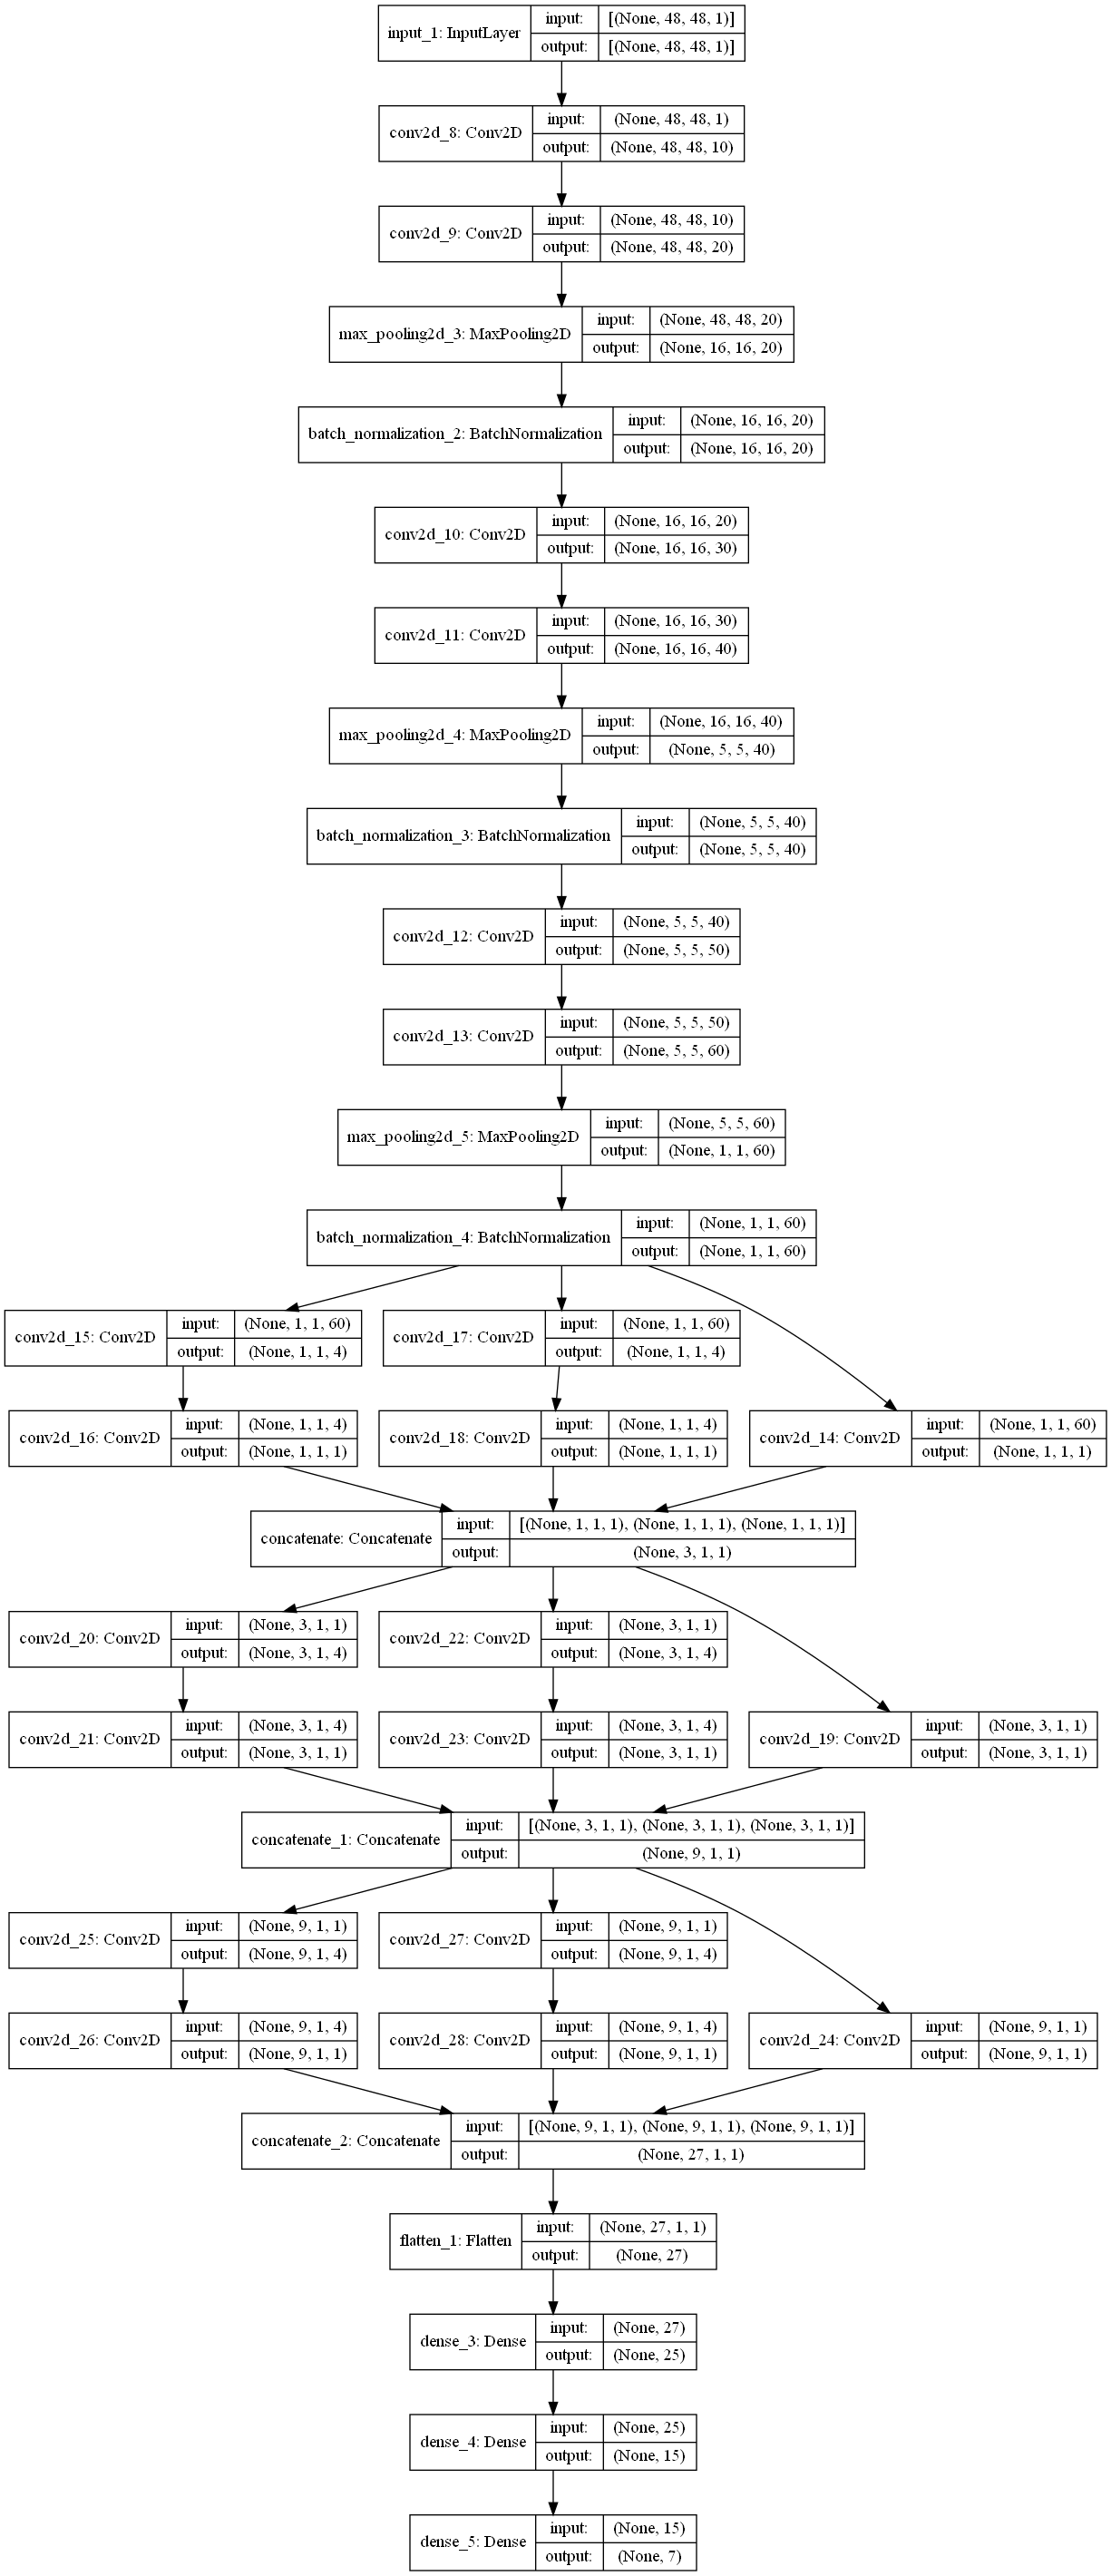

In [62]:
plot_model(model, to_file='data/model_images/model_plot_3.png', show_shapes=True, show_layer_names=True)

In [64]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 128
epochs = 10

# Fit the model on the batches generated by datagen.flow().

In [66]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

history = model.fit_generator(
    datagen.flow(X_train, train_labels_one_hot, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs, 
    validation_data=(X_test, test_labels_one_hot)
)

Epoch 1/10
225/225 [==============================] - 45s 193ms/step - loss: 1.7731 - accuracy: 0.2732 - val_loss: 1.8614 - val_accuracy: 0.1819
Epoch 2/10
225/225 [==============================] - 44s 195ms/step - loss: 1.6244 - accuracy: 0.3258 - val_loss: 1.8689 - val_accuracy: 0.2028
Epoch 3/10
225/225 [==============================] - 44s 196ms/step - loss: 1.5484 - accuracy: 0.3589 - val_loss: 1.6663 - val_accuracy: 0.3190
Epoch 4/10
225/225 [==============================] - 45s 200ms/step - loss: 1.4513 - accuracy: 0.4147 - val_loss: 1.4593 - val_accuracy: 0.4207
Epoch 5/10
225/225 [==============================] - 44s 198ms/step - loss: 1.3929 - accuracy: 0.4306 - val_loss: 1.4070 - val_accuracy: 0.4277
Epoch 6/10
225/225 [==============================] - 45s 199ms/step - loss: 1.3648 - accuracy: 0.4449 - val_loss: 1.3911 - val_accuracy: 0.4322
Epoch 7/10
225/225 [==============================] - 48s 215ms/step - loss: 1.3432 - accuracy: 0.4578 - val_loss: 1.3484 - val_ac

Text(0.5, 1.0, 'Accuracy Curves')

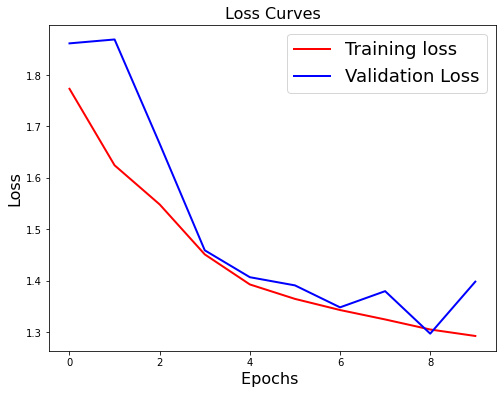

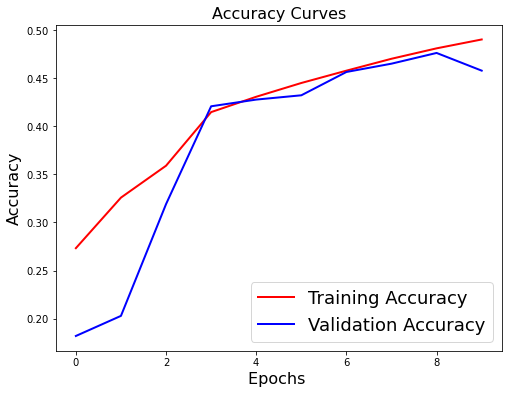

In [68]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [69]:
#save the model weights
json_string = model.to_json()
model.save_weights(local_path + 'savedmodels/model_deep_2.h5')
open(local_path + 'savedmodels/model_deep_2.json', 'w').write(json_string)
#model.save_weights(local_path + 'savedmodels/Emotion_Face_Detection_Model.h5')

18751

In [70]:
with open(local_path + 'savedmodels/model_deep_2.json','r') as f:
    json = f.read()
model = model_from_json(json)

model.load_weights(local_path + 'savedmodels/model_deep_2.h5')
print("Loaded model from disk")

Loaded model from disk


## X-Ception

In [75]:
def entry_flow(inputs) :
    
    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    previous_block_activation = x
    
    for size in [128, 256, 728] :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    
    return x

In [76]:
def middle_flow(x, num_blocks=8) :
    
    previous_block_activation = x
    
    for _ in range(num_blocks) :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    
    return x

In [77]:
def exit_flow(x, num_classes=7) :
    
    previous_block_activation = x
    
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])
      
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    return x

In [78]:
inputs = Input(shape=(shape_x, shape_y, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))

In [79]:
xception = Model(inputs, outputs)

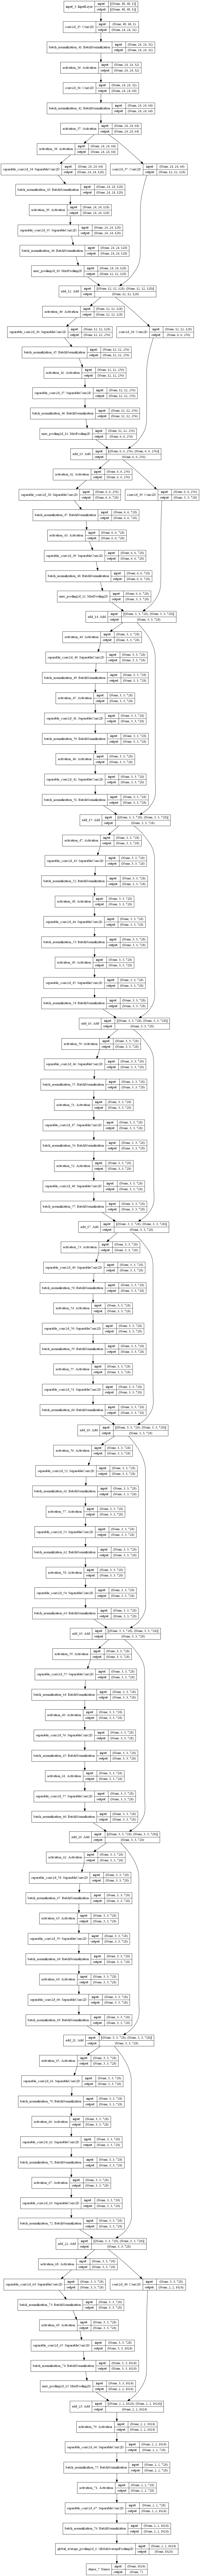

In [81]:
plot_model(xception, to_file='data/model_images/model_plot_4.png', show_shapes=True, show_layer_names=True)

In [82]:
xception.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 24, 24, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 24, 24, 32)   128         conv2d_35[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 24, 24, 32)   0           batch_normalization_41[0][0]     
____________________________________________________________________________________________

In [91]:
xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 128
epochs = 1

In [92]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

history = xception.fit_generator(
    datagen.flow(X_train, train_labels_one_hot, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs, 
    validation_data=(X_test, test_labels_one_hot)
)

225/225 [==============================] - 493s 2s/step - loss: 1.6186 - accuracy: 0.3614 - val_loss: 2.0708 - val_accuracy: 0.2494
